# Прогнозирование температуры звезд

Обсерватория «Небо на ладони» хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики:**
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- Тип звезды:
| Тип звезды                   | Номер, соответствующий типу |
|-----------------------------|----------------------------|
| Коричневый карлик            | 0                          |
| Красный карлик              | 1                          |
| Белый карлик                | 2                          |
| Звёзды главной последовательности | 3                  |
| Сверхгигант                 | 4                          |
| Гипергигант                 | 5                          |


**Справочная информация:**
- Светимость Солнца (англ. Average Luminosity of Sun): L₀ = 3.828 × 10²⁶ Вт
- Радиус Солнца (англ. Average Radius of Sun): R₀ = 6.9551 × 10⁸ м


**Задача:**
Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

### Установка программных пакетов и импорт необходимых библиотек.

In [1]:
#устанавливаем профайлер
!pip install ydata_profiling --quiet

In [2]:
#устанавливаем библиотеки

import itertools

import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.compose import ColumnTransformer

from ydata_profiling import ProfileReport

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader, TensorDataset

import copy
import random

SEED = 42
random.seed(SEED)                
np.random.seed(SEED)             
torch.manual_seed(SEED)          
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False     

### Загрузка данных.

In [3]:
data = pd.read_csv('6_class.csv', index_col=0)

## Предобработка и анализ данных

### Ознакомление с данными.

#### Выводим основную информацию для датафрейма методом info() и первые 10 строк датасета.

In [4]:
data.info()

data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0             3068          0.002400        0.1700                   16.12   
1             3042          0.000500        0.1542                   16.60   
2             2600          0.000300        0.1020                   18.70   
3             2800          0.000200        0.1600                   16.65   
4             1939          0.000138        0.1030                   20.06   
5             2840          0.000650        0.1100                   16.98   
6             2637          0.000730        0.1270                   17.22   
7             2600          0.000400        0.0960                   17.40   
8             2650          0.000690        0.1100                   17.45   
9             2700          0.000180        0.1300                   16.05   

   Star type Star color  
0          0        Red  
1          0        Red  
2          0        Red  
3          0        Red  
4          0        Red  
5          0        Red  
6          0        Red  
7          0        Red  
8          0        Red  
9          0        Red

#### Выводим основную информацию для датафрейма методом ProfileReport().

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Предварительные выводы:

**В данных выявлены следующие недостатки:**
- присутствуют неявные дубликаты;
- присутствуют количественные признаки с разными разбросами значений, которые необходимо масштабировать посредством стандартизации данных;
- присутствуют категориальные типы данных, которые необходимо преобразовать в численные для целей обучения нейросети.

### Предобработка данных.

#### Переименовываем столбцы в соответствии с требованиями PEP 8.

In [6]:
data = data.rename(columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'
})

#### Исключаем неявные дубликаты из столбца star_color.

In [7]:
#выводим список уникальных значений
data['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [8]:
#приводим значения столбца к нижнему регистру и удаляем пробелы в начале и конце
data['star_color'] = data['star_color'].str.strip().str.lower()

In [9]:
#удаляем иные неявные дубликаты
data['star_color'] = data['star_color'].replace('blue white', 'blue-white')

In [10]:
data['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            8
yellowish white         3
yellowish               3
whitish                 2
orange                  2
pale yellow orange      1
white-yellow            1
orange-red              1
Name: star_color, dtype: int64

In [11]:
#удаляем классы цветов, который очень мало
data = data.loc[data['star_color'].isin(['red','blue','blue_white','yellow_white','white'])]

#### Производим категоризацию количественных данных.

##### Производим категоризацию данных по относительной светимости L/Lo.

In [12]:
# создаем функцию для категоризации светимости
def categorize_luminosity(luminosity):
    if luminosity < 10**-4:
        return 'ultra low luminosity'
    elif 10**-4 <= luminosity < 10**-2:
        return 'very low luminosity'
    elif 10**-2 <= luminosity < 1:
        return 'low luminosity'
    elif 1 <= luminosity < 10**2:
        return 'solar luminosity'
    elif 10**2 <= luminosity < 10**4:
        return 'high luminosity'
    elif 10**4 <= luminosity < 10**6:
        return 'very high luminosity'
    else:
        return 'ultra high luminosity'

In [13]:
#создаем новый столбец
data['luminosity_cat'] = data['luminosity'].apply(categorize_luminosity)

##### Производим категоризацию данных по относительному радиусу R/Ro.

In [14]:
# создаем функцию для категоризации радиуса
def categorize_radius(radius):
    if radius < 0.01:
        return 'ultra small radius'
    elif 0.01 <= radius < 0.1:
        return 'very small radius'
    elif 0.1 <= radius < 1:
        return 'small radius'
    elif 1 <= radius < 10:
        return 'solar radius'
    elif 10 <= radius < 100:
        return 'large radius'
    elif 100 <= radius < 1000:
        return 'very large radius'
    else:
        return 'ultra large radius'

In [15]:
# создаем новый столбец
data['radius_cat'] = data['radius'].apply(categorize_radius)

##### Производим категоризацию данных по абсолютной звёздной величине Mv.

In [16]:
# создаем функцию для категоризации абсолютной звёздной величины
def categorize_magnitude(mv):
    if mv < 0:
        return 'ultra bright'
    elif 0 <= mv < 5:
        return 'very bright'
    elif 5 <= mv < 10:
        return 'bright'
    elif 10 <= mv < 15:
        return 'dim'
    else:
        return 'very dim'

In [17]:
# создаем новый столбец
data['magnitude_cat'] = data['magnitude'].apply(categorize_magnitude)

### Анализ предобработанных данных.

In [18]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Выводы:**

- Аномальные значения в количественных признаках не выявлены. Вместе с тем, в данных содержатся данные о звездах, имеющих характеристики из максимально широкого диапазона.

- Типы звезд представлены в данных равномерно.

- Выявлена наибольшая корелляция температуры от типа звезды (≈0.6), абсолютной звёздной величины (≈-0.5) и относительной светимости (≈0.5).

### Разбиваем датасет на обучающую и тестовую выборки.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['temperature']), 
    data.temperature, 
    test_size=0.3, 
    shuffle=True,
    random_state=SEED,
    stratify=data['star_type'])

### Нормализуем входные данные.

In [20]:
numeric = ['luminosity', 'radius', 'magnitude']
categorical = ['star_type', 'star_color', 'luminosity_cat', 'radius_cat', 'magnitude_cat']
col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), numeric),
                                ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

### Преобразовываем данные в формат тензора.

In [21]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.FloatTensor(y_train.values).squeeze()
y_test = torch.FloatTensor(y_test.values).squeeze()

## Построение базовой нейронной сети

### Создаем функцию обучения и определения модели нейронной сети.

In [22]:
%%time

class StarTempPredictor(nn.Module):
    def __init__(self, layer_structure):
        super(StarTempPredictor, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(25, layer_structure[0]))  # входной слой

        for i in range(len(layer_structure) - 1):
            self.layers.append(nn.Linear(layer_structure[i], layer_structure[i+1]))  # скрытые слои

        self.layers.append(nn.Linear(layer_structure[-1], 1))  # выходной слой
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
            
        x = self.layers[-1](x)
        
        return x.squeeze()

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu') 
        nn.init.normal_(layer.bias, mean=0.5, std=0.7)

def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.008, early_stopping_patience=75):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    best_rmse = float('inf')
    best_model = copy.deepcopy(model.state_dict())

    no_improve_epochs = 0
    epochs = 0

    while True:
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        with torch.no_grad():
            model.eval()
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
            rmse = torch.sqrt(test_loss).item()

            if epochs % 100 == 0:
                print(f'Эпоха {epochs} - train loss: {loss.item()}, test loss: {test_loss.item()}')

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping at epoch {epochs}')
            break
        epochs += 1
        if epochs >= 10000:
            print('Reached max number of epochs, stopping')
            break

    model.load_state_dict(best_model)
    return model, train_losses, test_losses

CPU times: total: 0 ns
Wall time: 0 ns


### Подбираем наилучшую архитектуру нейросети по количеству скрытых слоев и нейронов в них с выводом метрик и графика обучения.

Эпоха 0 - train loss: 191320896.0, test loss: 191545664.0
Эпоха 100 - train loss: 40448508.0, test loss: 47096540.0
Эпоха 200 - train loss: 18741014.0, test loss: 19958436.0
Эпоха 300 - train loss: 15773863.0, test loss: 17074994.0
Эпоха 400 - train loss: 15425500.0, test loss: 16442163.0
Эпоха 500 - train loss: 15133017.0, test loss: 15901689.0
Эпоха 600 - train loss: 14666444.0, test loss: 15119010.0
Эпоха 700 - train loss: 14000683.0, test loss: 13584801.0
Эпоха 800 - train loss: 13199005.0, test loss: 12454976.0
Эпоха 900 - train loss: 12732023.0, test loss: 11741269.0
Эпоха 1000 - train loss: 12451738.0, test loss: 11836788.0
Early stopping at epoch 1083
Эпоха 0 - train loss: 191326064.0, test loss: 191542784.0
Эпоха 100 - train loss: 39854724.0, test loss: 47319784.0
Эпоха 200 - train loss: 17133886.0, test loss: 18244072.0
Эпоха 300 - train loss: 15448739.0, test loss: 16576999.0
Эпоха 400 - train loss: 14971079.0, test loss: 16202197.0
Эпоха 500 - train loss: 13444806.0, test l

Эпоха 300 - train loss: 15513342.0, test loss: 16903722.0
Эпоха 400 - train loss: 15368580.0, test loss: 16513761.0
Early stopping at epoch 470
Эпоха 0 - train loss: 191281872.0, test loss: 191432640.0
Эпоха 100 - train loss: 28562258.0, test loss: 31484402.0
Эпоха 200 - train loss: 15637604.0, test loss: 17328870.0
Эпоха 300 - train loss: 15046432.0, test loss: 16543864.0
Эпоха 400 - train loss: 14485727.0, test loss: 15849926.0
Эпоха 500 - train loss: 13672554.0, test loss: 15426376.0
Эпоха 600 - train loss: 12558149.0, test loss: 14563973.0
Эпоха 700 - train loss: 11428883.0, test loss: 12984530.0
Эпоха 800 - train loss: 10729692.0, test loss: 12730773.0
Эпоха 900 - train loss: 10309972.0, test loss: 12041732.0
Эпоха 1000 - train loss: 10287807.0, test loss: 11685684.0
Early stopping at epoch 1073
Эпоха 0 - train loss: 191397088.0, test loss: 191509792.0
Эпоха 100 - train loss: 36946876.0, test loss: 42427728.0
Эпоха 200 - train loss: 16861718.0, test loss: 18302574.0
Эпоха 300 - tr

Эпоха 100 - train loss: 34156640.0, test loss: 38758004.0
Эпоха 200 - train loss: 16325775.0, test loss: 17943752.0
Эпоха 300 - train loss: 15462043.0, test loss: 16833156.0
Эпоха 400 - train loss: 15289691.0, test loss: 16632034.0
Эпоха 500 - train loss: 15143293.0, test loss: 16548201.0
Эпоха 600 - train loss: 14991060.0, test loss: 16460023.0
Эпоха 700 - train loss: 14809948.0, test loss: 16294367.0
Эпоха 800 - train loss: 14568009.0, test loss: 16260813.0
Early stopping at epoch 835
Эпоха 0 - train loss: 191231808.0, test loss: 191438672.0
Эпоха 100 - train loss: 37142564.0, test loss: 42668688.0
Эпоха 200 - train loss: 17224614.0, test loss: 18639680.0
Эпоха 300 - train loss: 15595316.0, test loss: 17320754.0
Эпоха 400 - train loss: 15352776.0, test loss: 16857284.0
Эпоха 500 - train loss: 15158336.0, test loss: 16586446.0
Эпоха 600 - train loss: 14874066.0, test loss: 16251942.0
Эпоха 700 - train loss: 14539794.0, test loss: 15798537.0
Early stopping at epoch 793
Эпоха 0 - train 

Эпоха 300 - train loss: 15335716.0, test loss: 16946776.0
Эпоха 400 - train loss: 15130830.0, test loss: 16627085.0
Эпоха 500 - train loss: 14748685.0, test loss: 16095480.0
Эпоха 600 - train loss: 14221044.0, test loss: 15428141.0
Эпоха 700 - train loss: 13353873.0, test loss: 14013624.0
Эпоха 800 - train loss: 11635886.0, test loss: 12189760.0
Эпоха 900 - train loss: 9470772.0, test loss: 11434014.0
Эпоха 1000 - train loss: 8782559.0, test loss: 11729595.0
Early stopping at epoch 1013
Эпоха 0 - train loss: 191266976.0, test loss: 191389904.0
Эпоха 100 - train loss: 25275412.0, test loss: 27521424.0
Эпоха 200 - train loss: 15707334.0, test loss: 17179078.0
Эпоха 300 - train loss: 15363205.0, test loss: 16548475.0
Эпоха 400 - train loss: 14996177.0, test loss: 16286604.0
Эпоха 500 - train loss: 13944562.0, test loss: 15699378.0
Эпоха 600 - train loss: 12511960.0, test loss: 15293992.0
Early stopping at epoch 640
Эпоха 0 - train loss: 191318000.0, test loss: 191538832.0
Эпоха 100 - trai

Эпоха 300 - train loss: 15526680.0, test loss: 16825486.0
Эпоха 400 - train loss: 15320928.0, test loss: 16467314.0
Эпоха 500 - train loss: 15170814.0, test loss: 16332767.0
Эпоха 600 - train loss: 15001290.0, test loss: 16280152.0
Эпоха 700 - train loss: 14810217.0, test loss: 16118076.0
Early stopping at epoch 776
Эпоха 0 - train loss: 191237904.0, test loss: 191361520.0
Эпоха 100 - train loss: 29065750.0, test loss: 32204562.0
Эпоха 200 - train loss: 15758993.0, test loss: 17344090.0
Эпоха 300 - train loss: 15389457.0, test loss: 16642605.0
Эпоха 400 - train loss: 15219039.0, test loss: 16423938.0
Эпоха 500 - train loss: 15027142.0, test loss: 16203288.0
Эпоха 600 - train loss: 14730283.0, test loss: 15813760.0
Эпоха 700 - train loss: 14107964.0, test loss: 15033562.0
Эпоха 800 - train loss: 13173998.0, test loss: 14514526.0
Эпоха 900 - train loss: 12168973.0, test loss: 12918519.0
Эпоха 1000 - train loss: 11898115.0, test loss: 12514065.0
Эпоха 1100 - train loss: 11166648.0, test l

Эпоха 100 - train loss: 23949100.0, test loss: 25361330.0
Эпоха 200 - train loss: 15580126.0, test loss: 17049276.0
Эпоха 300 - train loss: 15256305.0, test loss: 16589523.0
Эпоха 400 - train loss: 14918788.0, test loss: 16310955.0
Эпоха 500 - train loss: 14211149.0, test loss: 15726946.0
Эпоха 600 - train loss: 13454152.0, test loss: 15109922.0
Эпоха 700 - train loss: 12812807.0, test loss: 14524293.0
Эпоха 800 - train loss: 11877170.0, test loss: 14491419.0
Early stopping at epoch 812
Эпоха 0 - train loss: 191273568.0, test loss: 191480688.0
Эпоха 100 - train loss: 27893876.0, test loss: 30996606.0
Эпоха 200 - train loss: 15751646.0, test loss: 17135960.0
Эпоха 300 - train loss: 15195789.0, test loss: 16482642.0
Эпоха 400 - train loss: 14532897.0, test loss: 16155691.0
Эпоха 500 - train loss: 13510033.0, test loss: 15370020.0
Эпоха 600 - train loss: 12057839.0, test loss: 14204283.0
Эпоха 700 - train loss: 10756968.0, test loss: 13597657.0
Early stopping at epoch 772
Эпоха 0 - train 

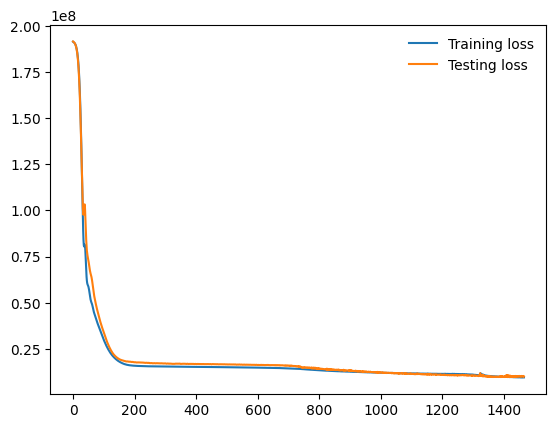

RMSE первичной модели: 3121.861083984375
Архитектура первичной модели: (20, 60, 60, 20)
CPU times: total: 8min 35s
Wall time: 4min 33s


In [23]:
%%time

neurons_per_layer = [20, 40, 60]
max_hidden_layers = 4

best_rmse = float('inf')
best_model_structure = None
best_train_losses = []
best_test_losses = []

layer_structures = list(itertools.product(neurons_per_layer, repeat=max_hidden_layers))

for layer_structure in layer_structures:
    model = StarTempPredictor(layer_structure)
    model.apply(init_weights)
    
    model, train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)
    
    with torch.no_grad():
        model.eval()
        predictions = model(X_test)
        mse = F.mse_loss(predictions, y_test)
        rmse = torch.sqrt(mse).item()

        if rmse < best_rmse:
            best_rmse = rmse
            best_model_structure = layer_structure
            primary_model = model
            best_train_losses = train_losses
            best_test_losses = test_losses

# Plot losses for the best model
plt.plot(best_train_losses, label='Training loss')
plt.plot(best_test_losses, label='Testing loss')
plt.legend(frameon=False)
plt.show()

print('RMSE первичной модели:', best_rmse)
print('Архитектура первичной модели:', best_model_structure)

### Строим график "Факт-Прогноз".

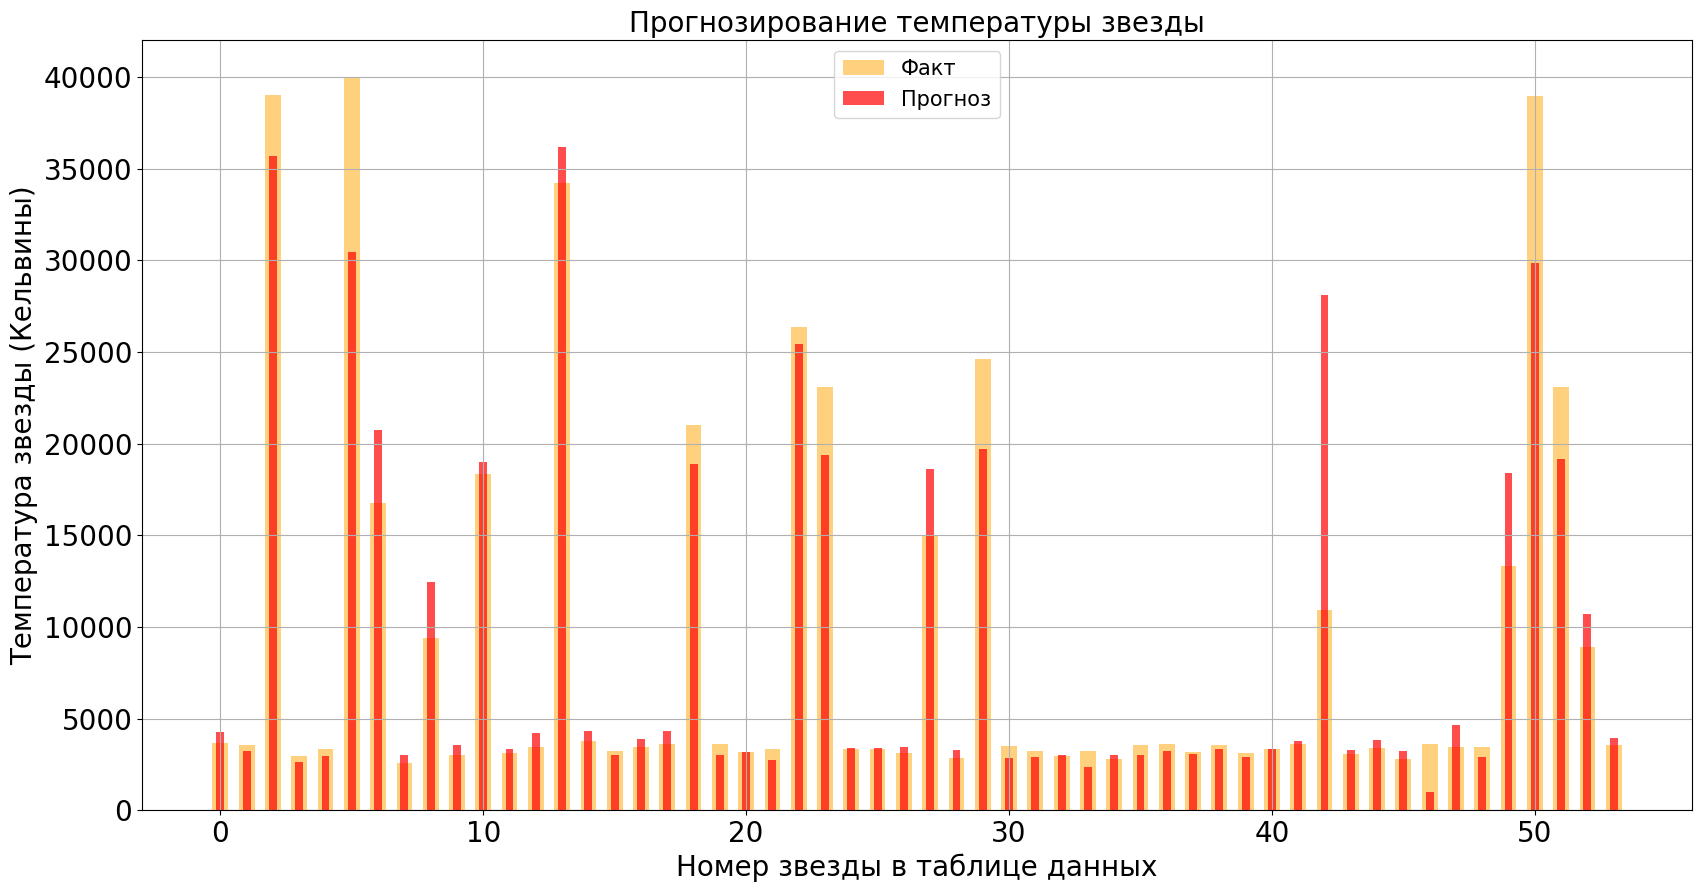

In [24]:
predictions = primary_model(X_test)
mse = F.mse_loss(predictions, y_test)
rmse = torch.sqrt(mse).item()

# Перевод модели в режим тестирования
model.eval()

# Получение прогнозов модели на тестовом наборе данных
predictions = model(X_test)

# Номера звезд для оси X
stars = np.arange(len(y_test))

# Фактические и прогнозируемые значения
y_test_np = y_test.detach().numpy().flatten()
predictions_np = predictions.detach().numpy().flatten()

# Размеры фигуры
plt.figure(figsize=(20, 10))

# Построение графика для фактических значений с оранжевыми столбцами
plt.bar(stars, y_test_np, width=0.6, label='Факт', color='orange', alpha=0.5)

# Построение графика для прогнозируемых значений с красными столбцами, накладывающимися по центру столбцов фактических данных
plt.bar(stars, predictions_np, width=0.3, label='Прогноз', color='red', alpha=0.7)

plt.title('Прогнозирование температуры звезды', fontsize=20)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды (Кельвины)', fontsize=20)
plt.legend(fontsize=15)

# Увеличение размера шрифта значений по осям
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.show()


### Вывод:

- Модель довольно дает приемлемые (за редким исключением) по точности предсказания относительно объектов, фактическая температура которых не превышает 10000 Кельвинов.
- Вместе с тем, точность предсказаний модели существенно снижается в отношении объектов, фактическая температура которых превышает 10000 Кельвинов.

## Улучшение нейронной сети

### Воссоздаем нейросеть с архитектурой, подобранной на предыдущем этапе.¶

In [25]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25, 20)
        self.fc2 = nn.Linear(20, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 20)
        self.fc5 = nn.Linear(20, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x.squeeze()  


### Создаем решение с перебором параметров нейронной сети.¶

Эпоха 0 - train loss: 191247632.0, test loss: 191419536.0
Эпоха 100 - train loss: 32816474.0, test loss: 30547440.0
Эпоха 200 - train loss: 20592960.0, test loss: 18796110.0
Early stopping at epoch 280


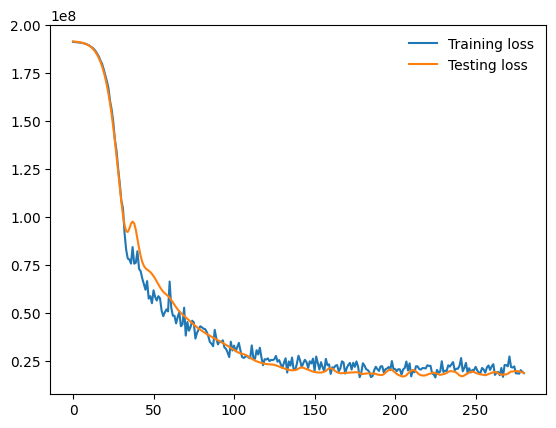

Эпоха 0 - train loss: 191183872.0, test loss: 191349456.0
Эпоха 100 - train loss: 29306494.0, test loss: 31972176.0
Эпоха 200 - train loss: 22496120.0, test loss: 20268134.0
Эпоха 300 - train loss: 18284186.0, test loss: 19205030.0
Early stopping at epoch 349


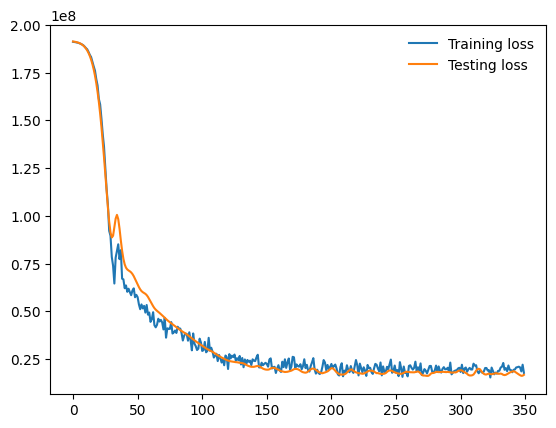

Эпоха 0 - train loss: 191174704.0, test loss: 191303472.0
Эпоха 100 - train loss: 28072332.0, test loss: 30088590.0
Эпоха 200 - train loss: 26760170.0, test loss: 18208512.0
Эпоха 300 - train loss: 16765737.0, test loss: 16889276.0
Early stopping at epoch 364


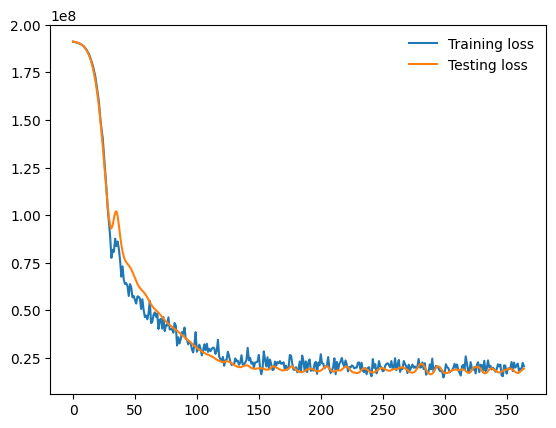

Эпоха 0 - train loss: 191244112.0, test loss: 191391216.0
Эпоха 100 - train loss: 33807784.0, test loss: 30672116.0
Эпоха 200 - train loss: 30222654.0, test loss: 23070338.0
Эпоха 300 - train loss: 31671736.0, test loss: 16848182.0
Early stopping at epoch 374


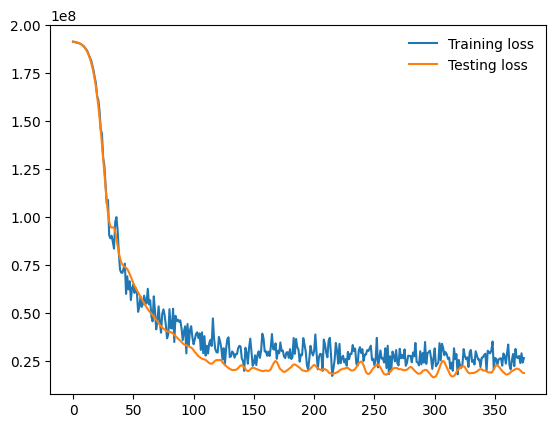

Эпоха 0 - train loss: 191219936.0, test loss: 191429936.0
Эпоха 100 - train loss: 38363064.0, test loss: 38675584.0
Эпоха 200 - train loss: 35795896.0, test loss: 21092816.0
Эпоха 300 - train loss: 26904058.0, test loss: 19827354.0
Early stopping at epoch 390


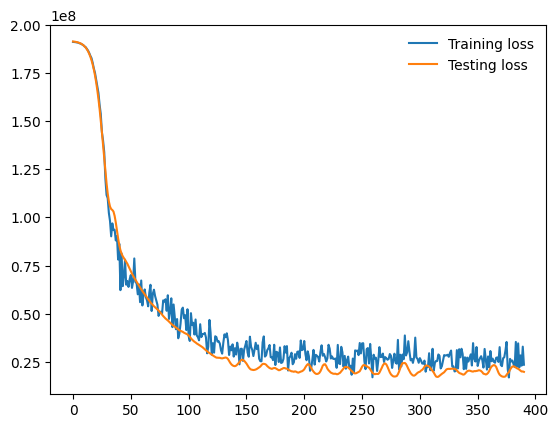

Эпоха 0 - train loss: 191194400.0, test loss: 191335392.0
Эпоха 100 - train loss: 46612948.0, test loss: 31331852.0
Эпоха 200 - train loss: 35503472.0, test loss: 24703486.0
Early stopping at epoch 283


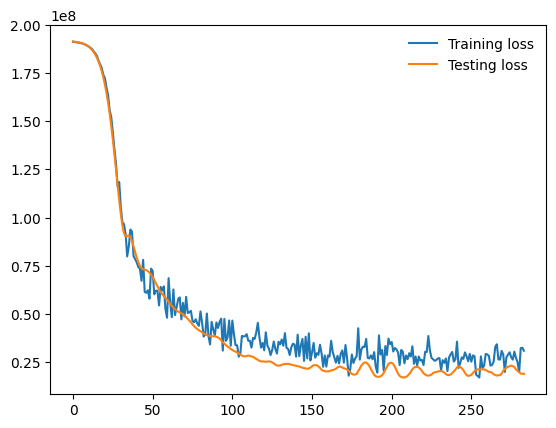

Эпоха 0 - train loss: 191292032.0, test loss: 191500400.0
Эпоха 100 - train loss: 51266488.0, test loss: 39066404.0
Эпоха 200 - train loss: 46453932.0, test loss: 25572114.0
Early stopping at epoch 231


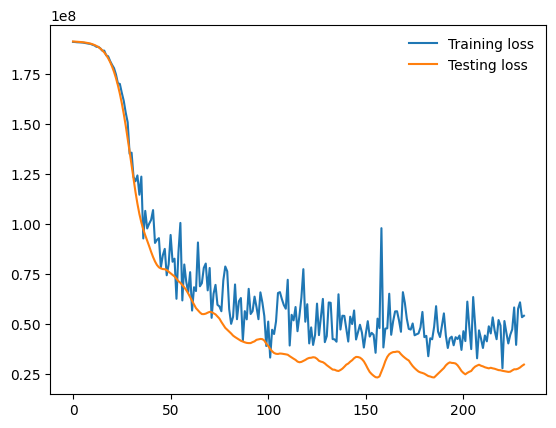

Эпоха 0 - train loss: 191424976.0, test loss: 191536912.0
Эпоха 100 - train loss: 63233004.0, test loss: 48507284.0
Эпоха 200 - train loss: 80440768.0, test loss: 32389532.0
Эпоха 300 - train loss: 42454544.0, test loss: 25632222.0
Early stopping at epoch 301


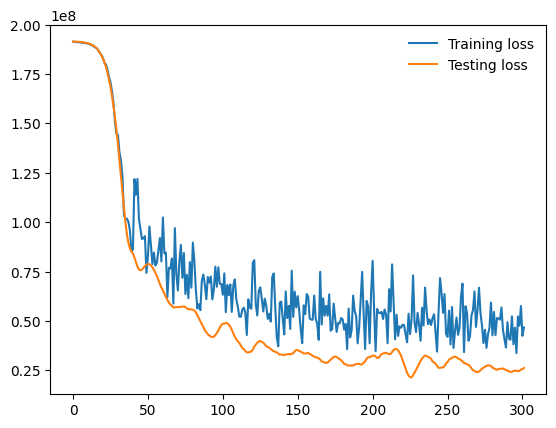

Эпоха 0 - train loss: 191391456.0, test loss: 191541856.0
Эпоха 100 - train loss: 67354024.0, test loss: 43688624.0
Эпоха 200 - train loss: 60272524.0, test loss: 33657080.0
Early stopping at epoch 287


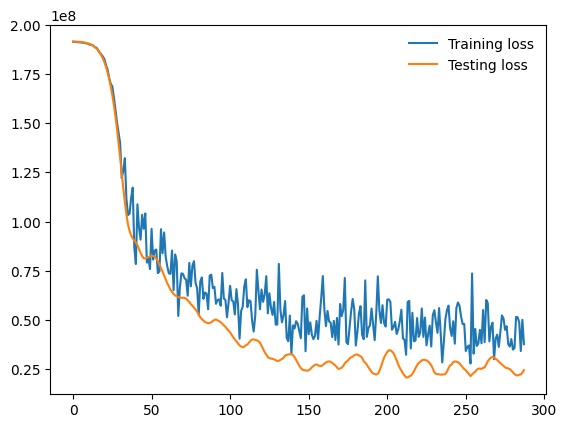

RMSE финальной модели: 4026.366455078125
Настройки финальной модели (Dropout, Batch size): (0.1, 64)
CPU times: total: 42.6 s
Wall time: 19.9 s


In [26]:
%%time

dropout_values = [0.1, 0.25, 0.5]
batch_sizes = [16, 32, 64]

best_rmse = float('inf')
best_model_structure = None

for dropout in dropout_values:
    for batch_size in batch_sizes:
        model = Net(dropout)
        model.apply(init_weights)
        
        loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size)
        X_train_batches, y_train_batches = zip(*list(loader))
        X_train_batches, y_train_batches = torch.cat(X_train_batches), torch.cat(y_train_batches)

        model, train_losses, test_losses = train_model(model, X_train_batches, y_train_batches, X_test, y_test)
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_test)
            mse = F.mse_loss(predictions, y_test)
            rmse = torch.sqrt(mse).item()

            if rmse < best_rmse:
                best_rmse = rmse
                best_model_structure = (dropout, batch_size)
                final_model = model

        # Plot losses
        plt.plot(train_losses, label='Training loss')
        plt.plot(test_losses, label='Testing loss')
        plt.legend(frameon=False)
        plt.show()

print('RMSE финальной модели:', best_rmse)
print('Настройки финальной модели (Dropout, Batch size):', best_model_structure)

### Строим график "Факт-Прогноз".

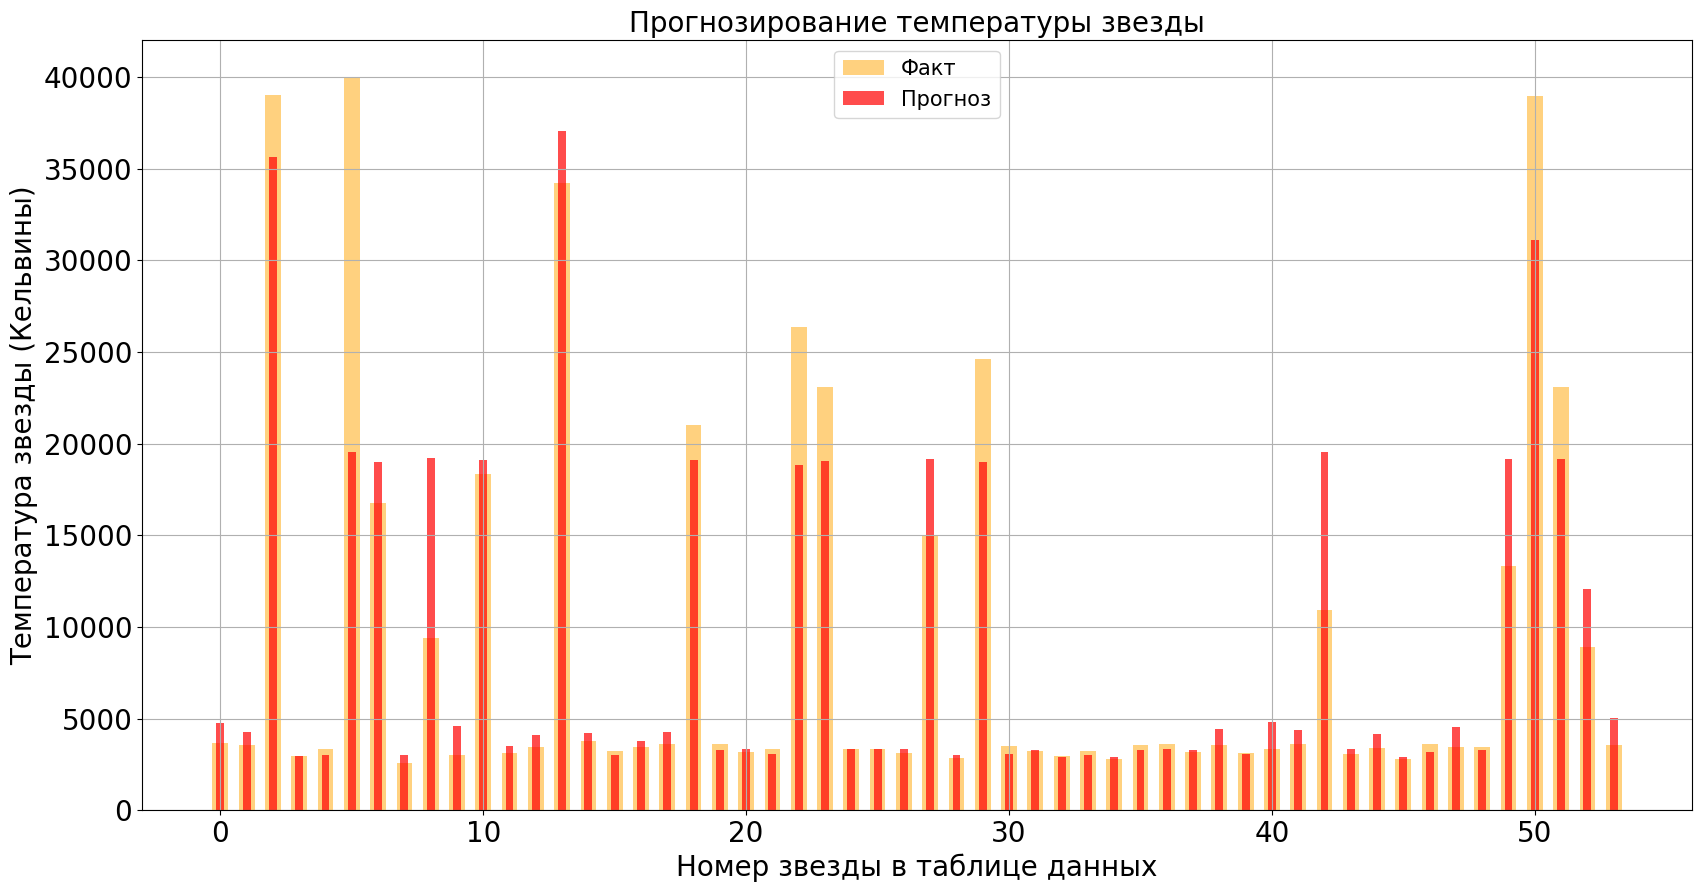

In [27]:
# Перевод модели в режим тестирования
final_model.eval()

# Получение прогнозов модели на тестовом наборе данных
predictions = final_model(X_test)

# Номера звезд для оси X
stars = np.arange(len(y_test))

# Фактические и прогнозируемые значения
y_test_np = y_test.detach().numpy().flatten()
predictions_np = predictions.detach().numpy().flatten()

# Размеры фигуры
plt.figure(figsize=(20, 10))

# Построение графика для фактических значений с оранжевыми столбцами
plt.bar(stars, y_test_np, width=0.6, label='Факт', color='orange', alpha=0.5)

# Построение графика для прогнозируемых значений с красными столбцами, накладывающимися по центру столбцов фактических данных
plt.bar(stars, predictions_np, width=0.3, label='Прогноз', color='red', alpha=0.7)

plt.title('Прогнозирование температуры звезды', fontsize=20)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды (Кельвины)', fontsize=20)
plt.legend(fontsize=15)

# Увеличение размера шрифта значений по осям
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.show()

### Вывод:

Регуляризация при помощи dropout и batches в данной случае не улучшила, а, наоборот, ухудшила качество модели.

## Выводы

- Нейросеть, подобранная изначально, позволила добиться метрики RMSE ≈ 3100 при целевой метрике 4500. В подборе оптимальных параметров нейросети очень сильно помогло внедрение алгоритма EarlyStopping и постепенное снижение learning rate.
- Добавление к выбранной нейросети параметров dropout и batches не привело к улучшению качества, а, наоборот, снизило целевую метрику RMSE до ≈ 4000, что, тем не менее, позволило достичь цели проекта.
- Таким образом, регуляризация не всегда приводит к улучшению качества нейросети.